In [171]:
from keras import optimizers
from keras.layers.core import Dense,Activation,Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import time
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler
from numpy import newaxis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [250]:
def load_data(filename, seq_len, normalise_window):
    f = open(filename, 'r').read()
    data = f.split('\n')

    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    if normalise_window:
        result = normalise_windows(result)

    result = np.array(result)

    #row = round(0.9 * result.shape[0])
    row = 192
    train = result[:int(row), :]
    np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

    return [x_train, y_train, x_test, y_test]

def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    for i in range(math.ceil(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()

In [156]:
train_df = pd.read_csv('PM_train.txt',sep=" ",header=None)
train_df.drop(train_df.columns[[26,27]],axis=1,inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                    's15', 's16', 's17', 's18', 's19', 's20', 's21']


In [136]:
def find_life_cycles_of_machine(train_df):
    dict_of_numbers = {}
    for val in train_df['id']:
        if val not in dict_of_numbers:
            dict_of_numbers[val] = 1
        else:
            dict_of_numbers[val]+=1
    print(dict_of_numbers)
    find_average_life_cycle(dict_of_numbers,len(dict_of_numbers))
    
def find_average_life_cycle(dict_of_machines,machine_n):
    sum_of_cycles = 0
    for machine_id in dict_of_machines:
        sum_of_cycles += dict_of_machines[machine_id]
    print(sum_of_cycles/machine_n)
    
find_life_cycles_of_machine(train_df)

{1: 192, 2: 287, 3: 179, 4: 189, 5: 269, 6: 188, 7: 259, 8: 150, 9: 201, 10: 222, 11: 240, 12: 170, 13: 163, 14: 180, 15: 207, 16: 209, 17: 276, 18: 195, 19: 158, 20: 234, 21: 195, 22: 202, 23: 168, 24: 147, 25: 230, 26: 199, 27: 156, 28: 165, 29: 163, 30: 194, 31: 234, 32: 191, 33: 200, 34: 195, 35: 181, 36: 158, 37: 170, 38: 194, 39: 128, 40: 188, 41: 216, 42: 196, 43: 207, 44: 192, 45: 158, 46: 256, 47: 214, 48: 231, 49: 215, 50: 198, 51: 213, 52: 213, 53: 195, 54: 257, 55: 193, 56: 275, 57: 137, 58: 147, 59: 231, 60: 172, 61: 185, 62: 180, 63: 174, 64: 283, 65: 153, 66: 202, 67: 313, 68: 199, 69: 362, 70: 137, 71: 208, 72: 213, 73: 213, 74: 166, 75: 229, 76: 210, 77: 154, 78: 231, 79: 199, 80: 185, 81: 240, 82: 214, 83: 293, 84: 267, 85: 188, 86: 278, 87: 178, 88: 213, 89: 217, 90: 154, 91: 135, 92: 341, 93: 155, 94: 258, 95: 283, 96: 336, 97: 202, 98: 156, 99: 185, 100: 200}
206.31


In [231]:
#Take s7 coloumn and train based on only that coloumn 
#machine1_df = pd.DataFrame(train_df['s7'].head(192)) #training dataset
#machine_df = pd.DataFrame(train_df[['cycle','s7']])[0:479]
machine_df = pd.DataFrame(train_df['s7'][0:479]) #testing dataset
#machine_dataset = machine_df.values
#machine_dataset = machine_dataset.astype('float32')
#print(machine_dataset)
machine_df.to_csv('sensor_val.csv',header=None,index=None,sep=',')

In [216]:
scaler = MinMaxScaler(feature_range=(0,1))
machine_dataset = scaler.fit_transform(machine_dataset)

<class 'numpy.ndarray'>


In [233]:
x_train,y_train,x_test,y_test = load_data('sensor_val.csv',50,True)
'''
train_size = int(len(machine_dataset)*0.40)+1
test_size = len(machine_dataset)-train_size
train = machine_dataset[:int(train_size), :]
x_train = train[:,[0]]
y_train = train[:,[1]]
test = machine_dataset[int(train_size):,:]
x_test = test[:,[0]]
y_test = test[:,[0]]
#np.random.shuffle(train)
'''



#train
x_train,x_test

(array([[[ 0.00000000e+00],
         [ 4.52955991e-04],
         [-6.52256627e-04],
         ...,
         [ 4.76509702e-03],
         [ 3.06198250e-03],
         [ 5.72536372e-03]],
 
        [[ 0.00000000e+00],
         [-1.23117034e-03],
         [-7.42323291e-04],
         ...,
         [ 4.39962341e-03],
         [ 4.16425261e-03],
         [ 4.49015064e-03]],
 
        [[ 0.00000000e+00],
         [ 1.68517948e-03],
         [ 1.46773697e-03],
         ...,
         [ 4.16764818e-03],
         [ 4.81997572e-03],
         [ 3.17103666e-03]],
 
        ...,
 
        [[ 0.00000000e+00],
         [ 1.87915583e-03],
         [ 3.61376120e-04],
         ...,
         [ 1.01185314e-03],
         [ 1.17447239e-03],
         [ 1.82494941e-03]],
 
        [[ 0.00000000e+00],
         [ 1.19314484e-03],
         [ 7.23118085e-05],
         ...,
         [-2.87439439e-03],
         [-4.51948803e-04],
         [-2.40436763e-03]],
 
        [[ 0.00000000e+00],
         [ 1.10094392e-03],
    

In [234]:
model = Sequential()

model.add(LSTM(input_dim=1,output_dim=50,return_sequences=True))

model.add(Dropout(0.2))

model.add(LSTM(100,
              return_sequences=False))

model.add(Dropout(0.2))

model.add(Dense(output_dim=1))

model.add(Activation('relu'))

start = time.time()
model.compile(loss='mse',optimizer='rmsprop')
print('compilation time:',time.time()-start)

c:\users\amrit\anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\amrit\anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(input_shape=(None, 1), units=50, return_sequences=True)`
  This is separate from the ipykernel package so we can avoid doing imports until


compilation time: 0.07001113891601562


c:\users\amrit\anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
  if sys.path[0] == '':


In [243]:
model.fit(
x_train,
y_train,
batch_size=128,
nb_epoch=5)

c:\users\amrit\anaconda3\envs\py35\lib\site-packages\keras\models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/5
192/192 [==============================] - 0s 2ms/step - loss: 7.2293e-06
Epoch 2/5
192/192 [==============================] - 0s 2ms/step - loss: 7.2293e-06
Epoch 3/5
192/192 [==============================] - 0s 2ms/step - loss: 7.2293e-06
Epoch 4/5
192/192 [==============================] - 0s 3ms/step - loss: 7.2293e-06
Epoch 5/5
192/192 [==============================] - 0s 2ms/step - loss: 7.2293e-06


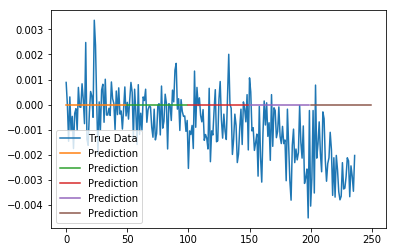

In [251]:
#step4: Plot the predictions
predictions = predict_sequences_multiple(model,x_test,50,50)
plot_results_multiple(predictions,y_test,50)